In [1]:
import os
import sys
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import re
import subprocess
import numpy as np
import math

%load_ext autoreload
%autoreload 2
%matplotlib inline

sys.path.append('../src')

In [3]:
pred_path = './fusion/'

In [83]:
subm2 = {
    'name': 'subm2',
    'folds': 4,
}

subm3_resnet = {
    'name': 'subm3(resnet)',
    'folds': 4,
}

subm3_svm = {
    'name': 'subm3(svm)',
    'folds': 4,
}

subm4 = {
    'name': 'subm4',
    'folds': 10,
}


subm4_rv3 = {
    'name': 'subm4(rv3)',
    'folds': 10,
}

subm4_rv4 = {
    'name': 'subm4(rv4)',
    'folds': 10,
}

In [77]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', color_map=plt.cm.Blues, fig_path=None):
        """
        This function prints and plots the confusion matrix
        """
        if not title:
            title = 'Confusion matrix'

            # Compute confusion matrix
        # Only use the labels that appear in the data
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Confusion matrix with normalization')
        np.set_printoptions(precision=3)
        print(norm_cm)
        print('Confusion matrix without normalization')
        print(cm)
        np.set_printoptions(precision=6)

        fig, ax = plt.subplots(figsize=(8, 6))
        im = ax.imshow(cm, interpolation='nearest', cmap=color_map)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

#         ax.set_xticks(np.arange(cm.shape[1] + 1)-.5)
#         ax.set_yticks(np.arange(cm.shape[0] + 1)-.5)

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, '{0:d}\n{1:.2f}%'.format(cm[i, j], norm_cm[i, j] * 100),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

        fig.tight_layout()
        if fig_path:
            plt.savefig(fig_path, dpi = 300)
        else:
            plt.show(block=False)

Fold: 0. Alpha: 0.5
Best UAR: 0.9155375319858867
Model 1 Uar: 0.9032579574874218
Model 2 Uar: 0.8939045514836567
Fold: 1. Alpha: 0.575
Best UAR: 0.9283610821302696
Model 1 Uar: 0.9171021622030429
Model 2 Uar: 0.9030905190292564
Fold: 2. Alpha: 0.5
Best UAR: 0.9285366454395554
Model 1 Uar: 0.9151611211073445
Model 2 Uar: 0.9105067620288531
Fold: 3. Alpha: 0.5
Best UAR: 0.9248881769314509
Model 1 Uar: 0.9142983584241925
Model 2 Uar: 0.9013021582463285
Fold: 4. Alpha: 0.5
Best UAR: 0.9193362720379343
Model 1 Uar: 0.909381480708523
Model 2 Uar: 0.8971718963575481
Fold: 5. Alpha: 0.525
Best UAR: 0.7371699582360021
Model 1 Uar: 0.7014560938695574
Model 2 Uar: 0.7123816433914119
Fold: 6. Alpha: 0.55
Best UAR: 0.7291875233848052
Model 1 Uar: 0.7111066448239947
Model 2 Uar: 0.7112911951784324
Fold: 7. Alpha: 0.5
Best UAR: 0.7211878132721199
Model 1 Uar: 0.6813354704095838
Model 2 Uar: 0.7075407780440697
Fold: 8. Alpha: 0.425
Best UAR: 0.7590369365345558
Model 1 Uar: 0.7142264227265449
Model 2 U

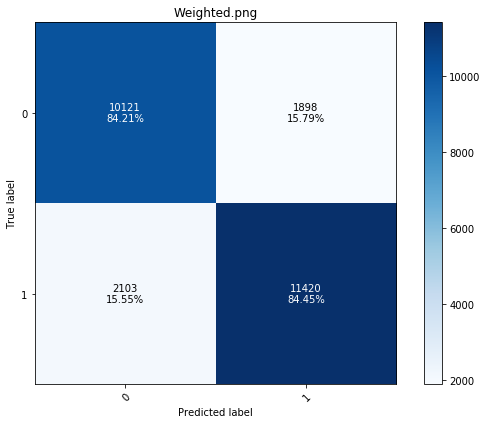

In [130]:
from sklearn.metrics import recall_score, confusion_matrix

uars = []
models = [subm4_rv3, subm4_rv4]
all_preds = []
all_targets = []
alphas = [0 for i in range(0, models[0]['folds'])]

all_test_preds = []
for i in range(0, models[0]['folds']):
    all_devel = []
    all_test = []
    for model_i in range(len(models)):
        devel_data = np.loadtxt(open(os.path.join(pred_path, "{}_devel_preds_{}.csv".format(models[model_i]['name'], i)), "rb"),
                                delimiter=",", skiprows=0)
        
        test_data = np.loadtxt(open(os.path.join(pred_path, "{}_test_preds_{}.csv".format(models[model_i]['name'], i)), "rb"),
                               delimiter=",", skiprows=0)
        all_devel.append((devel_data[:,0], devel_data[:,2]))
        all_test.append(test_data[:, 0])
        
    uar_max = 0
    for alpha in range(0, 41):
        alpha = alpha / 40
        preds = alpha * all_devel[0][0] + (1 - alpha) * all_devel[1][0]
        
        uar = recall_score(all_devel[0][1], np.asarray([0 if p > .5 else 1 for p in preds]), average='macro')
        if uar > uar_max:
            uar_max = uar
            alphas[i] = alpha
    
    preds = alphas[i] * all_devel[0][0] + (1 - alphas[i]) * all_devel[1][0]
    all_preds.append([0 if p > .5 else 1 for p in preds])
    all_targets.append(all_devel[0][1])
    print('Fold: {}. Alpha: {}'.format(i, alphas[i]))
    uars.append(uar_max)
    print('Best UAR: {}'.format(uar_max))
    print('Model 1 Uar: {}'.format(recall_score(all_devel[0][1], np.asarray([0 if p > .5 else 1 for p in all_devel[0][0]]), average='macro')))
    print('Model 2 Uar: {}'.format(recall_score(all_devel[1][1], np.asarray([0 if p > .5 else 1 for p in all_devel[1][0]]), average='macro')))
    
    test_preds = alphas[i] * all_test[0] + (1 - alphas[i]) * all_test[1]
    all_test_preds.append(test_preds)
    
print('Mean UAR: {}'.format(recall_score(np.concatenate(all_targets), np.concatenate(all_preds), average='macro')))
cm = confusion_matrix(np.concatenate(all_targets), np.concatenate(all_preds), [0, 1])
res_name = 'Weighted'
plot_confusion_matrix(cm=cm, classes=[0, 1], title='{}.png'.format(res_name), fig_path=None)

In [150]:
pred_file_name = 'ComParE2020_Mask.{0}.test.IIAS_5.csv'.format('mel_64')

file_names = pd.read_csv('ComParE2020_Mask.mel_64.test.IIAS_4.csv')['file_name'].values
testing_predicts = np.mean(np.stack(all_test_preds), axis=0)

submission_df = pd.DataFrame.from_dict({'file_name': [f for f in file_names], 
                                        'prediction': ['clear' if pred > .5 else 'mask' for pred in testing_predicts]})

submission_df.to_csv(pred_file_name, index=False)

In [157]:
# D=63.4 | T=70.8
test_top_1 = pd.read_csv('../src/applications/ComParE2020_Mask.DeepSpectrum_resnet50.test.baseline_1.csv')

# D=77.232 | T=74.0
subm1 = pd.read_csv('ComParE2020_Mask.mel_64.test.IIAS_1.csv')

# D=79.127 | T=75.1
subm2 = pd.read_csv('ComParE2020_Mask.mel_64.test.IIAS_2.csv')

# D=82.17 | T=75.3
subm4 = pd.read_csv('ComParE2020_Mask.mel_64.test.IIAS_4.csv')

new_subm = pd.read_csv('ComParE2020_Mask.mel_64.test.IIAS_5.csv')

In [158]:
test_top_1['predMatch_subm1?'] = np.where(test_top_1['prediction'] == subm1['prediction'], 'True', 'False')

test_top_1['predMatch_subm2?'] = np.where(test_top_1['prediction'] == subm2['prediction'], 'True', 'False')

test_top_1['predMatch_subm4?'] = np.where(test_top_1['prediction'] == subm4['prediction'], 'True', 'False')

test_top_1['predMatch_subm5?'] = np.where(test_top_1['prediction'] == new_subm['prediction'], 'True', 'False')

In [159]:
test_top_1.describe()

,file_name,prediction,predMatch_subm1?,predMatch_subm2?,predMatch_subm4?,predMatch_subm5?
count,11012,11012,11012,11012,11012,11012
unique,11012,2,2,2,2,2
top,test_07001.wav,mask,True,True,True,True
freq,1,5695,7720,7846,7840,7923


In [160]:
subm4['predMatch_new_subm?'] = np.where(subm4['prediction'] == new_subm['prediction'], 'True', 'False')

In [161]:
subm4.describe()

,file_name,prediction,predMatch_new_subm?
count,11012,11012,11012
unique,11012,2,2
top,test_07001.wav,clear,True
freq,1,6551,10629
